# Importing necessary libraries

In [59]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn import svm
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import Imputer
import sklearn
import pandas
import random
import matplotlib.pyplot as plt
%matplotlib inline  

# Reading in file and defining variables

In [60]:
filter_by_baseline_flag = True
add_scale_cols_onehotencoder = True
add_missing_01_cols = True

raw_data = pandas.read_csv('contactid_08_29_18.csv', encoding="utf-8") 

raw_data_copy = raw_data

#Filling in empty cells

raw_data['Min days between calls'].fillna(0, inplace=True)
raw_data['Max days between calls'].fillna(0, inplace=True)
raw_data['Min days between texts'].fillna(0, inplace=True)
raw_data['Max days between texts'].fillna(0, inplace=True)  

raw_data.shape

(18265, 57)

# Filtering by baseline_flag

In [61]:
if filter_by_baseline_flag:
    baseline_flag_raw_data = raw_data.loc[raw_data['baseline_flag']==0]
    

# Adding in columns for 0/1 for texts and calls

In [62]:
if add_missing_01_cols:
    calls_raw_data = pandas.get_dummies(raw_data['Total number of calls'], dummy_na=True, prefix='Calls')
    texts_raw_data = pandas.get_dummies(raw_data['Total number of texts'], dummy_na=True, prefix='Texts')

    text_call_columns_data = pandas.concat([raw_data, calls_raw_data['Calls_nan']],axis=1)
    text_call_columns_data = pandas.concat([text_call_columns_data, texts_raw_data['Texts_nan']],axis=1)

# Updating scale colunn to be replaced with onehotencoder layout

In [64]:
if add_scale_cols_onehotencoder:
    # use pandas.concat to join the new columns with dataframe
    scale_columns_raw_data = pandas.concat([raw_data,pandas.get_dummies(raw_data['scale'], prefix='scale')],axis=1)

    # now drop the original 'scale' column because we wont need it anymore
    scale_columns_raw_data.drop(['scale'],axis=1, inplace=True) 

In [66]:
# We only want to consider data in which the "Close" column has data
# so that is the first thing we filter and we train/test on that new DataFrame

close_raw_data = raw_data.loc[raw_data['close'].notnull()]

# found some counterexamples where baseline_flag being 1, equated to closeness being 60,80....so not sure what to do with this
# dfclean_baseline = updated_raw_data.loc[updated_raw_data['baseline_flag']==0]

# This will show us (# of rows, # of columns)
close_raw_data.shape

(2869, 57)

In [67]:
# Now we look over the workable data and see how clean it is

num_of_cells = close_raw_data.shape[0]*close_raw_data.shape[1]
num_of_cells

163533

In [68]:
# We look at all the columns with NaN values

df_null_columns = ((close_raw_data.isnull().sum()/close_raw_data.shape[0])*100).round(decimals=2).astype(str) + '%'
df_null_columns.to_frame('nulls')
#df_null_columns

,nulls
subjectid,0.0%
scale,0.0%
age,0.0%
black,0.0%
tot.child,0.03%
health.sr,0.0%
diag,0.0%
shelter,0.0%
recstay.yrs,0.0%
ageinc,0.0%


In [69]:
# We also look at all the rows with at least one NaN value

df_null_rows = close_raw_data.isnull().sum(axis=1)
# df_null_rows

In [70]:
# The percentage of rows missing at least one value would be

(((df_null_rows!=0).sum()/(df_null_rows.shape[0]))*100).round(decimals=2).astype(str) + '%'

'14.4%'

In [71]:
# And lastly we consider missing cells in relation to all total cells 

num_of_missing_cells = (close_raw_data.isnull().sum()).sum()
((num_of_missing_cells/num_of_cells)*100).round(decimals=2).astype(str) + '%'

'0.35%'

In [ ]:
#Now we begin to train/test the data, in hopes of being able to most accurately predict the closeness column for the original file

# We begin by looking at 2 different introductory Models that helps us visualize the data

#GradientBoostingClassifier
#GradientBoostingRegressor

In [74]:
# Before we begin with these Models, we need to format the data in a manner in which we can work with
dfclean = close_raw_data.fillna(-1)

In [78]:
all_cols = set(dfclean.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xdata = dfclean[[i for i in all_cols]].values

In [79]:
# We implement a random 80/20 split of the data to be used for train/test

random.seed = 0
indices = np.array(range(2869))
random.shuffle(indices)
num_train = int(len(indices)*0.8)
train_indices = indices[:num_train]
#print(train_indices.shape)
test_indices =indices[num_train+1:]
#print(test_indices.shape)

# # namimg variables that will be used for training/testing
xtrain = xdata[train_indices]
xtest = xdata[test_indices]

# ravel creates 1d array
y = dfclean[['close']].values.ravel()
ytrain = y[train_indices]
ytest = y[test_indices]

# GradientBoostingClassifier

(array([ 200.,    0.,  140.,    0.,  113.,    0.,  356.,    0.,  345.,
        1141.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

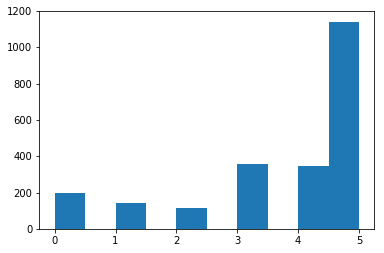

In [80]:
# GradientBoostingClassifier

def transform(ytrain):
    if ytrain < 20:
        return 0
    if ytrain < 40:
        return 1
    if ytrain < 60:
        return 2
    if ytrain < 80:
        return 3
    if ytrain < 100:
        return 4
    return 5


ytrainClassifier = [transform(i) for i in ytrain]
ytestClassifier = [transform(i) for i in ytest]
# ytestClassifier
# xtrain.shape,ytrain.shape
plt.hist(ytrainClassifier)

In [81]:
GBclassifier = GradientBoostingClassifier().fit(xtrain,ytrainClassifier)

yhatClassifier = GBclassifier.predict(xtrain)
yhatClassifier

array([5, 3, 5, ..., 0, 1, 3])

(array([ 46.,   0.,   9.,   0.,   9.,   0.,  30.,   0.,  36., 443.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

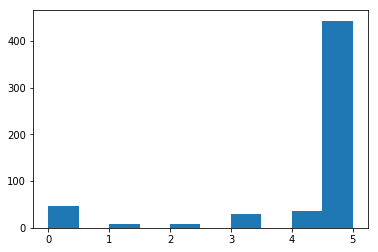

In [82]:
yhatClassifier = GBclassifier.predict(xtest)
accuracy_score(ytestClassifier, yhatClassifier)
plt.hist(yhatClassifier)

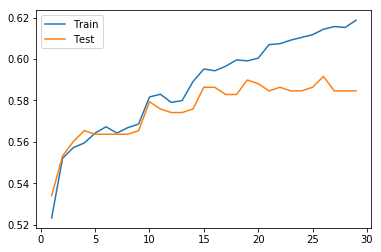

In [83]:
n_estimators = []
train_err = []
test_err = []

for n_estimator in range(1,30): #[1,2,3,4,5,10,20,50]:
    GBclassifier = GradientBoostingClassifier(n_estimators=n_estimator).fit(xtrain,ytrainClassifier)
    yhatClassifier = GBclassifier.predict(xtrain)
    n_estimators.append(n_estimator)
    train_err.append(accuracy_score(ytrainClassifier, yhatClassifier))
    test_err.append(accuracy_score(ytestClassifier, GBclassifier.predict(xtest)))
    
plt.plot(n_estimators, train_err, label="Train")
plt.plot(n_estimators, test_err, label="Test")
plt.legend()

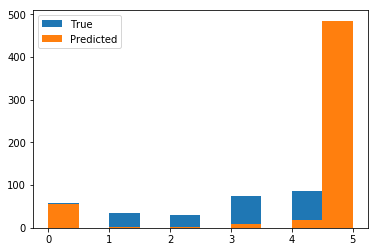

In [84]:
GBclassifier = GradientBoostingClassifier(n_estimators=20).fit(xtrain,ytrainClassifier)
plt.hist(ytestClassifier, label="True")
plt.hist(GBclassifier.predict(xtest), label="Predicted")
plt.legend()

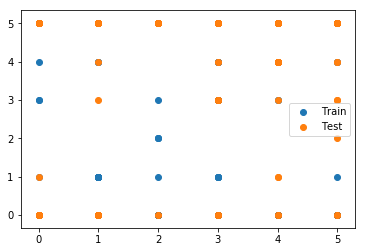

In [85]:
plt.scatter(ytrainClassifier, GBclassifier.predict(xtrain), label="Train")
plt.scatter(ytestClassifier, GBclassifier.predict(xtest), label="Test")
plt.legend()

# GradientBoostingRegressor

In [88]:
# GradientBoostingRegressor

In [89]:
GBregressor = GradientBoostingRegressor().fit(xtrain,ytrain)
yhatRegressor = GBregressor.predict(xtrain)
yhatRegressor

array([94.6184385 , 65.07029045, 79.91266538, ..., 29.34261445,
       73.06614626, 75.74703001])

In [90]:
yhatRegressor = GBregressor.predict(xtest)
mean_squared_error(ytest, yhatRegressor)

599.6148866299102

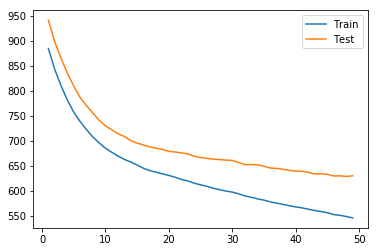

In [93]:
n_estimators = []
train_err = []
test_err = []

for n_estimator in range(1,50): #[1,2,3,4,5,10,20,50]:
    GBregressor = GradientBoostingRegressor(n_estimators=n_estimator).fit(xtrain,ytrain)
    yhatRegressor = GBregressor.predict(xtrain)
    n_estimators.append(n_estimator)
    train_err.append(mean_squared_error(ytrain, yhatRegressor))
    test_err.append(mean_squared_error(ytest, GBregressor.predict(xtest)))
    
plt.plot(n_estimators, train_err, label="Train")
plt.plot(n_estimators, test_err, label="Test")
plt.legend()

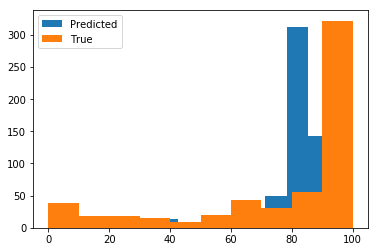

In [94]:
GBregressor = GradientBoostingRegressor(n_estimators=30).fit(xtrain,ytrain)
plt.hist(GBregressor.predict(xtest), label="Predicted")
plt.hist(ytest, label="True")
plt.legend()

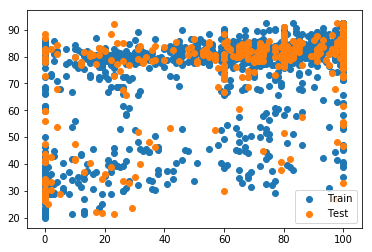

In [95]:
plt.scatter(ytrain, GBregressor.predict(xtrain), label="Train")
plt.scatter(ytest, GBregressor.predict(xtest), label="Test")
plt.legend()

In [96]:
# We finally look at 2 different Advanced Models that helps us visualize the data
# SVR
# MLPRegressor
# Before we begin with these Models, we need to format the data in a manner in which we can work with

In [98]:
# Imputer and formatting data
# Before we begin with these Models, we need to format the data in a manner in which we can work with, but this time, is a smarter manner using an Imputer to populate missing values for us

all_cols = set(dfclean.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xmissing = dfclean[[i for i in all_cols]].values

# dfRawFilled = pandas.DataFrame(data=xdata)
imp = Imputer()
xdataimputed = imp.fit_transform(xmissing)
xdataimputed

array([[1., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 3.],
       [0., 0., 1., ..., 1., 1., 3.],
       [0., 0., 0., ..., 1., 1., 3.]])

In [99]:
xdataimputed.shape

(2869, 50)

In [100]:
# We implement a random 80/20 split of the data to be used for train/test
# namimg variables that will be used for training/testing
xtrain = xdataimputed[train_indices]
xtest = xdataimputed[test_indices]

# ravel creates 1d array
y = dfclean[['close']].values.ravel()
ytrain = y[train_indices]
ytest = y[test_indices]

# SVR

In [101]:
# SVR

svr = SVR(kernel='rbf', C=1e1, epsilon=0.2)
svr.fit(xtrain, ytrain)
yhatsvr = svr.predict(xtest)
yhatsvr

array([ 86.40749479,  91.29838326,  91.55873759,  91.24699988,
        87.18528429,  91.24699988,  91.24699988,  91.24640972,
        91.24658672,  91.24699988,  91.27018829,  91.24699988,
        87.77413279,  91.25052488,  91.24699988,  91.24700019,
        87.89882666,  91.24699988,  91.2555197 ,  91.24699988,
        92.12656612,  91.24699988,  91.24699988,  91.41461552,
        91.24699976,  93.31321063,  91.24699988,  91.24538298,
        91.24699988,  91.24699988,  91.2470002 ,  91.3916171 ,
        87.43066192,  91.24660725,  95.42127115,  86.55233884,
        91.24699988,  91.24864611,  91.24921576,  91.2317732 ,
        91.58098525,  90.17502664,  91.24699988,  91.22200682,
        91.23644102,  91.24699988,  91.24699988,  91.24699988,
        91.24699988,  91.24699988,  91.2114123 ,  91.24699988,
        91.24699988,  91.24699988,  91.24699988,  91.24699988,
        91.24706113,  91.24699988,  91.24699988,  91.24702728,
        91.24749116,  91.24699988,  91.28491406,  91.24

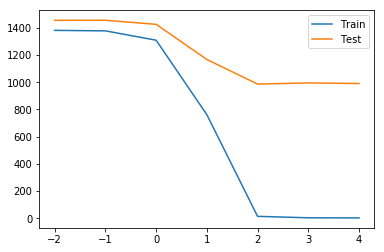

In [104]:
lCs = []
train_err = []
test_err = []

for lC in range(-2,5): #[1,2,3,4,5,10,20,50]: range(1,30)
    svr = SVR(kernel='rbf', C=pow(10,lC)).fit(xtrain,ytrain)
    lCs.append(lC)
    train_err.append(mean_squared_error(ytrain, svr.predict(xtrain)))
    test_err.append(mean_squared_error(ytest, svr.predict(xtest)))
    
plt.plot(lCs, train_err, label="Train")
plt.plot(lCs, test_err, label="Test")
plt.legend()

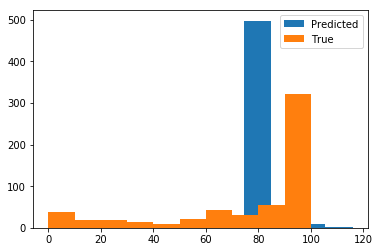

In [105]:
svr = SVR(kernel='rbf', C=1e2).fit(xtrain,ytrain)
plt.hist(svr.predict(xtest), label="Predicted")
plt.hist(ytest, label="True")
plt.legend()

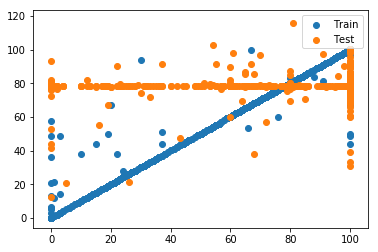

In [106]:
plt.scatter(ytrain, svr.predict(xtrain), label="Train")
plt.scatter(ytest, svr.predict(xtest), label="Test")
plt.legend()

# MLPRegressor

In [110]:
# MLPRegressor
mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(5,2))
mlp.fit(xtrain, ytrain)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [111]:
yhat = mlp.predict(xtest)
mean_squared_error(ytest, mlp.predict(xtest))

994.8731750922242

(array([  0.,   0.,   0.,   0.,   0., 573.,   0.,   0.,   0.,   0.]),
 array([77.3993464, 77.4993464, 77.5993464, 77.6993464, 77.7993464,
        77.8993464, 77.9993464, 78.0993464, 78.1993464, 78.2993464,
        78.3993464]),
 <a list of 10 Patch objects>)

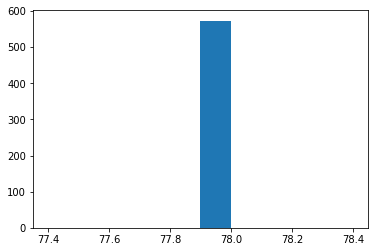

In [112]:
plt.hist(yhat)

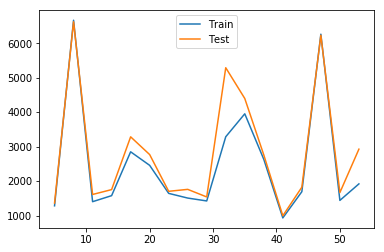

In [113]:
hs = []
train_err = []
test_err = []

for h in range(5,55,3): #[1,2,3,4,5,10,20,50]: range(1,30)
    mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(h,5))
    mlp.fit(xtrain, ytrain)
    hs.append(h)
    train_err.append(mean_squared_error(ytrain, mlp.predict(xtrain)))
    test_err.append(mean_squared_error(ytest, mlp.predict(xtest)))
    
plt.plot(hs, train_err, label="Train")
plt.plot(hs, test_err, label="Test")
plt.legend()

In [116]:
all_cols = set(raw_data.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xdatafull = dfclean[[i for i in all_cols]].values

In [118]:
dfRawFilledFull = pandas.DataFrame(data=xdatafull)
#print(dfRawFilledFull)

In [119]:
imp = Imputer()
imp.fit(dfRawFilledFull)
imp.transform(dfRawFilledFull.values)
dfRawFilledFull = pandas.DataFrame(data=(imp.transform(dfRawFilledFull.values)))
dfRawFilledFull

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.0,0.0,1.0,0.0,14.0,0.0,119.0,4.0,2.0,0.666667,...,0.0,1.0,4.0,6.0,1.0,0.0,2.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,258.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,404.0,0.0,0.0,1.000000,...,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,12343.0,24.0,3.0,0.830189,...,1.0,0.0,93.0,159.0,1.0,0.0,2.0,1.0,1.0,3.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.666667,...,1.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.000000,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,1.0,309.0,4.0,0.0,0.500000,...,0.0,0.0,6.0,8.0,1.0,1.0,2.0,1.0,1.0,2.0
7,1.0,0.0,0.0,0.0,2.0,0.0,583.0,2.0,5.0,0.750000,...,0.0,0.0,5.0,8.0,1.0,0.0,1.0,1.0,1.0,2.0
8,0.0,0.0,1.0,0.0,22.0,1.0,1197.0,21.0,8.0,0.526316,...,0.0,0.0,28.0,38.0,1.0,0.0,2.0,0.0,1.0,1.0
9,1.0,0.0,1.0,1.0,39.0,0.0,5483.0,10.0,3.0,0.936170,...,0.0,1.0,22.0,47.0,1.0,1.0,2.0,1.0,1.0,0.0


In [120]:
# num_of_cols = dfRawFilledFull.columns.size
# num_of_cols_array = []
# for i in range(num_of_cols):
#     num_of_cols_array.append(i)
    
# print(num_of_cols_array)


# update x to use values that have been populated now
xdatafullColumns = dfRawFilledFull[[i for i in range(dfRawFilledFull.columns.size)]].values

In [121]:
# debugging
xdatafullColumns.shape

(2869, 50)

In [ ]:
GBregressor = GradientBoostingRegressor().fit(xtrain,ytrain)
yhatRegressor = GBregressor.predict(xdatafullColumns)

# Do one last final predict on best results and feed out 
updated_raw_data['Predicted Closeness'] = yhatRegressor

In [ ]:
# Finally we write out the new dataFrame with the "Predicted Closeness" column

dfPredictions = raw_data.to_csv('Updated_Closeness_Predictions_base%s_scale%s_missing%s.csv' % (filter_by_baseline, add_scale_cols, add_missing_01_cols), encoding="utf-8")